In [1]:
import h5py
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pytorch_msssim
import warnings
warnings.filterwarnings("ignore")
import pathlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_size=128
batch_size=1

In [2]:
def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.LeakyReLU(0.2, inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    
class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels,stride=2, padding=1,droup=False):
        super(Upsample, self).__init__()
        self.modules = []
        self.modules.append(nn.ConvTranspose2d(Input_Channels, Output_Channels, kernel_size=4, stride=stride, padding=padding, bias=False))
        self.modules.append(nn.BatchNorm2d(Output_Channels))
        if droup:
            self.modules.append(nn.Dropout(0.5))
        self.modules.append(nn.LeakyReLU(0.2, inplace=True))
        self.model=nn.Sequential(*self.modules)

    def forward(self, x, skip_input):
        x = self.model(x)
        #print(f"x.shape{x.shape}")
        #print(f"x.shape{skip_input.shape}")
        x = torch.cat((x, skip_input), 1)
        return x    



class Generator128(nn.Module):
	def __init__(self, ngpu):
		super(Generator128, self).__init__()
		#self.ngpu = ngpu
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                #nn.Dropout(0.1)
                                )#64*64

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),#16*16
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#32*32
		#self.res1 = nn.Sequential(convT_block(128, 128), convT_block(128, 128))
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1)
                                )#16
        
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#8
		self.conv4_=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#4*4
                
		#self.res2 = nn.Sequential(convT_block(512, 512), convT_block(512, 512))
        
		self.conv5=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=0, bias=False)
                                 #, nn.Sigmoid()
                                )#1
        
		self.convT1 =Upsample(512,512,droup=True, padding=0)#4*4
		self.convT2_ = Upsample(512*2,512,droup=True)#8*8
		self.convT2 = Upsample(512*2,256,droup=True)#1*16*16
        
		self.resT1 = nn.Sequential(conv_block(256*2, 256*2), conv_block(256*2, 256*2))
        
		self.convT3 =Upsample(256*2,128)#1*32*32
		self.convT4 =Upsample(128*2,64)#1*64*64
		self.resT2 = nn.Sequential(conv_block(64*2, 64*2), conv_block(64*2, 64*2))
		self.convT5=nn.Sequential(  nn.ConvTranspose2d(64*2, 1, kernel_size=4, stride=2, padding=1, bias=False))
#1*128*128

            #nn.Conv2d(64*2, 1, kernel_size=4, stride=2, padding=1, bias=False))


	def forward(self, input):
#		print(input.shape)        
		out1 = self.conv1(input)
#		print(out1.shape)        
		out2 = self.conv2(out1)
#		print(out2.shape)        
		#out = self.res1(out) + out
		out3 = self.conv3(out2)
#		print(out3.shape)        
		out4 = self.conv4(out3)
#		print(out4.shape)        
		out4_ = self.conv4_(out4)
#		print(out4_.shape)        
		#out = self.res2(out) + out
		out5 = self.conv5(out4_)  
#		print(out5.shape)        
       
		outT1 = self.convT1(out5,out4_)
#		print(outT1.shape)        
		outT2_ = self.convT2_(outT1,out4)
#		print(outT2_.shape)        
		outT2 = self.convT2(outT2_,out3)
#		print(outT2.shape)        
		outT3 = self.resT1(outT2) + outT2#############
#		print(outT3.shape)        
		outT4 = self.convT3(outT3,out2)
#		print(outT4.shape)        
		outT5 = self.convT4(outT4,out1)
#		print(outT5.shape)        
		outT6 = self.resT2(outT5) + outT5###########
#		print(outT6.shape)        
		outT7 = self.convT5(outT6)
#		print(outT7.shape)        
		return outT7

# Function to calculate the characteristic of the protein's structure distance matrix.
## BackBone on natural protein 3.78A
## Short on natural protein 7.5A
## Long on natural protein 20.31A

In [3]:
image_size=128

def ckeckBackBone(fake_images,image_size=image_size,batch_size=13):#4
    #BackBone
    sum=0
    avgBatch=0
    batch=batch_size
    for b in range(batch):
        for i in range(image_size):
            for j in range(i+1,image_size):
                sum+=fake_images[b][0][i][j]
                break
        avgPeptiedBond=(sum/image_size)
        sum=0
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    #print("avg peptide bond BackBone protien for batch" ,(avgBatch/batch))
    return (avgBatch/batch)
    


def ckeckshort(fake_images,image_size=image_size,batch_size=13):#10
    #short
    avgBatch=0
    batch=batch_size
    imgSize_4=(image_size-4)
    for b in range(batch):
        sum=0
        for i in range(image_size):
            for j in range(i,imgSize_4,4):
                #print("distance(",i,",",j,") :",s)
                sum+=(fake_images[b][0][i][j+2]+fake_images[b][0][i][j+3]+fake_images[b][0][i][j+4])/3
                break
        avgPeptiedBond=(sum/imgSize_4)
        #print("avg peptide bond protien",b," : " ,avgPeptiedBond)
        avgBatch+=avgPeptiedBond
    #print("avg peptide bond short protien for batch" ,(avgBatch/batch))
    return (avgBatch/batch)


    
def ckeckLong(fake_images,image_size=image_size,batch_size=13):#20
    #Long
    batch=batch_size
    bsum=0
    c=0
    for b in range(batch):
        msum=0
        for i in range(image_size-5):
            sum=0
            for j in range(i+5,(image_size)):
                sum+=fake_images[b][0][i][j]
            sum/=(j+1-(i+5))
            msum+=sum
        bsum+=(msum/image_size)
    #print("avg peptide bond Long protien for batch" ,(bsum/batch))
    return (bsum/batch)


def show_image(fake_images,index=0,image_size=image_size):
    import seaborn as sns
    sns.heatmap((fake_images[index].view(image_size,image_size).detach().numpy()))

    
def Bhattacharyya(arrOfx,arrOfy):
    with torch.no_grad():
        #print(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy))).shape)
        print(torch.nansum(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy)))))
        return 1-torch.log(torch.nansum(torch.sqrt((arrOfx/torch.sum(arrOfx))*(arrOfy/torch.sum(arrOfy)))))
batch_size=128
image_size=128


In [4]:
#data_path = pathlib.Path("/home/mena/dataSets/dataset.hdf5")
#with h5py.File(data_path, "r") as data_file:
#    Tx2 = data_file[f"train_{image_size}"][:]
#len(Tx2)

# all Sizes


In [5]:
image_size=128



import numpy as np

from numpy import sqrt 
def areSameMatrix(A,B):
    diff=0
    n=len(A)
    for i in range(n):
        for j in range(n):
            diff+=pow((A[i][j] -B[i][j]),2)
    return sqrt(diff/(n*n)) 

def areSameInpainting(A,B,mask):
    lengthMask=image_size*mask+image_size*mask
    diff=0
    n=len(A)
    for i in range(n):
        for j in range(n):
            diff+=pow((A[i][j] -B[i][j]),2)
    return sqrt(diff/lengthMask) 

def getNoise(mask):
    noiseArrT = torch.ones(size=(batch_size,1,image_size, image_size)).to("cpu",dtype=torch.float32)
    for a in noiseArrT :
        im=np.random.randint(image_size-mask)
        a[0][im:im+ mask,:]=0
        a[0][:,im:im+mask]=0
    return noiseArrT
    
#print(np.mean(l))

In [6]:

def getNoise(mask):
    noiseArrT = torch.ones(size=(batch_size,1,image_size, image_size)).to("cpu",dtype=torch.float32)
    for a in noiseArrT :
        im=np.random.randint(image_size-mask)
        a[0][im:im+ mask,:]=0
        a[0][:,im:im+mask]=0
    return noiseArrT
    

In [7]:

from tqdm.auto import tqdm
batch_size=128
data_path = pathlib.Path("H:/p2/dataset_Test.hdf5")
numB=1
with h5py.File(data_path, "r") as data_file:
    Tx = data_file[f"test_{image_size}"][:128*1]
len(Tx)
dataloaderT = DataLoader(Tx, batch_size=batch_size, shuffle=True)#, num_workers=workers)

gen=Generator128(0)


TotalNBackBoneDist=[]
TotalNshortDist=[]
TotalNLongDist=[]


TotalARRareSameInpainting_5=[]
TotalARRareSameInpaintingMM_5=[]
TotalARRareSameMatrix_5=[]
TotalBackBoneDist_5=[]
TotalshortDist_5=[]
TotalLongDist_5=[]

TotalARRareSameInpainting_10=[]
TotalARRareSameInpaintingMM_10=[]
TotalARRareSameMatrix_10=[]
TotalBackBoneDist_10=[]
TotalshortDist_10=[]
TotalLongDist_10=[]

TotalARRareSameInpainting_15=[]
TotalARRareSameInpaintingMM_15=[]
TotalARRareSameMatrix_15=[]
TotalBackBoneDist_15=[]
TotalshortDist_15=[]
TotalLongDist_15=[]

TotalARRareSameInpainting_20=[]
TotalARRareSameInpaintingMM_20=[]
TotalARRareSameMatrix_20=[]
TotalBackBoneDist_20=[]
TotalshortDist_20=[]
TotalLongDist_20=[]

TotalARRareSameInpainting_25=[]
TotalARRareSameInpaintingMM_25=[]
TotalARRareSameMatrix_25=[]
TotalBackBoneDist_25=[]
TotalshortDist_25=[]
TotalLongDist_25=[]

TotalARRareSameInpainting_30=[]
TotalARRareSameInpaintingMM_30=[]
TotalARRareSameMatrix_30=[]
TotalBackBoneDist_30=[]
TotalshortDist_30=[]
TotalLongDist_30=[]

TotalARRareSameSSIMRegen_30=[]
TotalARRareSameSSIMRegen_25=[]
TotalARRareSameSSIMRegen_20=[]
TotalARRareSameSSIMRegen_15=[]
TotalARRareSameSSIMRegen_10=[]
TotalARRareSameSSIMRegen_5=[]


for maskN in tqdm([5,10,15,20,25,30]):
    s=3855
    print(f"------------------------------maskN:{maskN}------------------------------------------")
    for i in tqdm(range(5,201,5)):
        gen.load_state_dict(torch.load(f"E:/BigGpuFinalEd/Home/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{s}_epoch_{i}.pth",map_location="cpu")["gen"])
        s=s+3855
        #print(f"epoch {i}")
        ARRareSameInpainting_region=[]
        ARRareSameInpaintingMM=[]
        ARRareSameSSIMRegen=[]
        ARRareSameMatrix=[]
        BackBoneDist=[]
        shortDist=[]
        LongDist=[]
        NBackBoneDist=[]
        NshortDist=[]
        NLongDist=[]
        for d in dataloaderT:   
            data=d.reshape(batch_size,1,image_size,image_size).to("cpu",dtype=torch.float32)
            noiseArrT=getNoise(maskN)
            d0=data*noiseArrT
            comp_noiseArrT=(noiseArrT*-1)+1
            with torch.no_grad():
                reg_data=gen(d0).to("cpu")#gen
                
                #show_image(d1,index=1,image_size=128)
                ARRareSameSSIMRegen+=[pytorch_msssim.ssim(reg_data*comp_noiseArrT, data*comp_noiseArrT)]
                BackBoneDist+=[ckeckBackBone(reg_data,image_size=image_size,batch_size=batch_size)]
                shortDist+=[ckeckshort(reg_data,image_size=image_size,batch_size=batch_size)]
                LongDist+=[ckeckLong(reg_data,image_size=image_size,batch_size=batch_size)]
                if maskN ==5:
                    NBackBoneDist+=[ckeckBackBone(data,image_size=image_size,batch_size=batch_size)]
                    NshortDist+=[ckeckshort(data,image_size=image_size,batch_size=batch_size)]
                    NLongDist+=[ckeckLong(data,image_size=image_size,batch_size=batch_size)]
                for index in range(0,batch_size):
                    Inp_data=(data[index][0]*noiseArrT[index][0])+(reg_data[index][0]*comp_noiseArrT[index][0])
                    reg_region=reg_data[index][0]*comp_noiseArrT[index][0]
                    data_region=data[index][0]*comp_noiseArrT[index][0]
                    ARRareSameInpaintingMM.append(torch.sqrt(torch.sum(torch.pow(torch.tensor(Inp_data)-torch.tensor(data[index][0]),2))/(image_size*image_size)))
                    ARRareSameInpainting_region.append(torch.sqrt(torch.sum(torch.pow(torch.tensor(reg_region)-torch.tensor(data_region),2))/(image_size*maskN*2)))
                    ARRareSameMatrix.append(torch.sqrt(torch.sum(torch.pow(torch.tensor(data[index][0]) -torch.tensor(reg_data[index][0]),2))/(image_size*image_size)))
                    
        if maskN ==5:
            TotalARRareSameInpaintingMM_5.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_5.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_5.append(np.mean(ARRareSameMatrix))
            TotalBackBoneDist_5.append(np.mean(BackBoneDist))
            TotalARRareSameSSIMRegen_5.append(np.mean(ARRareSameSSIMRegen))
            TotalshortDist_5.append(np.mean(shortDist))
            TotalLongDist_5.append(np.mean(LongDist))
            TotalNBackBoneDist.append(np.mean(NBackBoneDist))
            TotalNshortDist.append(np.mean(NshortDist))
            TotalNLongDist.append(np.mean(NLongDist))
        elif maskN ==10:
            TotalARRareSameInpaintingMM_10.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_10.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_10.append(np.mean(ARRareSameMatrix))
            TotalARRareSameSSIMRegen_10.append(np.mean(ARRareSameSSIMRegen))
            TotalBackBoneDist_10.append(np.mean(BackBoneDist))
            TotalshortDist_10.append(np.mean(shortDist))
            TotalLongDist_10.append(np.mean(LongDist))
        elif maskN ==15:
            TotalARRareSameInpaintingMM_15.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_15.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_15.append(np.mean(ARRareSameMatrix))
            TotalARRareSameSSIMRegen_15.append(np.mean(ARRareSameSSIMRegen))
            TotalBackBoneDist_15.append(np.mean(BackBoneDist))
            TotalshortDist_15.append(np.mean(shortDist))
            TotalLongDist_15.append(np.mean(LongDist))
        elif maskN ==20:
            TotalARRareSameInpaintingMM_20.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_20.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_20.append(np.mean(ARRareSameMatrix))
            TotalARRareSameSSIMRegen_20.append(np.mean(ARRareSameSSIMRegen))
            TotalBackBoneDist_20.append(np.mean(BackBoneDist))
            TotalshortDist_20.append(np.mean(shortDist))
            TotalLongDist_20.append(np.mean(LongDist))
        elif maskN ==25:
            TotalARRareSameInpaintingMM_25.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_25.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_25.append(np.mean(ARRareSameMatrix))
            TotalARRareSameSSIMRegen_25.append(np.mean(ARRareSameSSIMRegen))
            TotalBackBoneDist_25.append(np.mean(BackBoneDist))
            TotalshortDist_25.append(np.mean(shortDist))
            TotalLongDist_25.append(np.mean(LongDist))
        else:
            TotalARRareSameInpaintingMM_30.append(np.mean(ARRareSameInpaintingMM))
            TotalARRareSameInpainting_30.append(np.mean(ARRareSameInpainting_region))
            TotalARRareSameMatrix_30.append(np.mean(ARRareSameMatrix))
            TotalARRareSameSSIMRegen_30.append(np.mean(ARRareSameSSIMRegen))
            TotalBackBoneDist_30.append(np.mean(BackBoneDist))
            TotalshortDist_30.append(np.mean(shortDist))
            TotalLongDist_30.append(np.mean(LongDist))


  0%|          | 0/6 [00:00<?, ?it/s]

------------------------------maskN:5------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

------------------------------maskN:10------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

------------------------------maskN:15------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

------------------------------maskN:20------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

------------------------------maskN:25------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

------------------------------maskN:30------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

####################********Test dataset******###############################


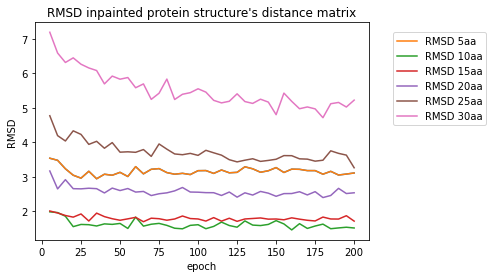

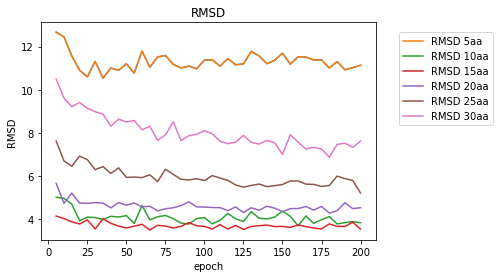

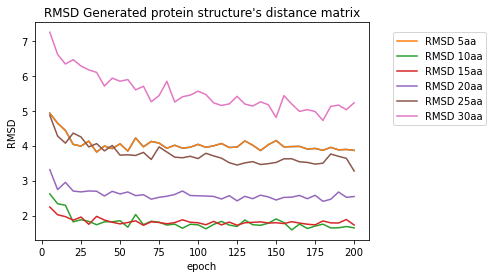

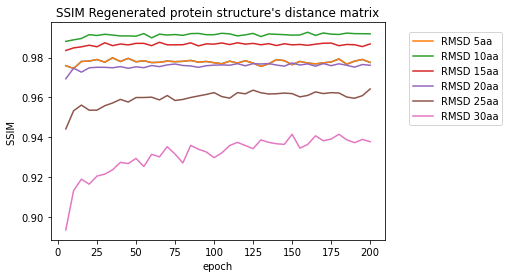

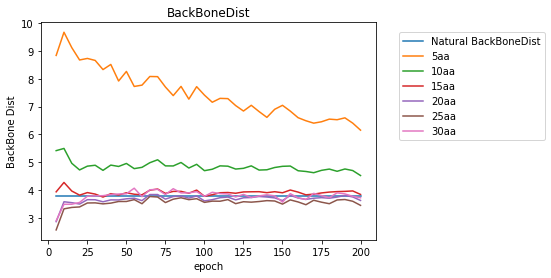

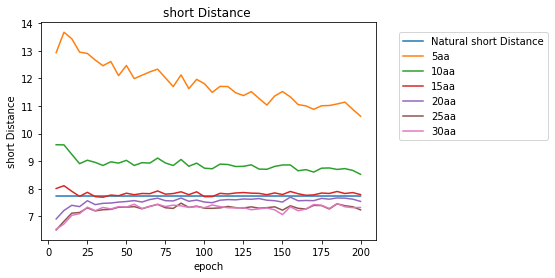

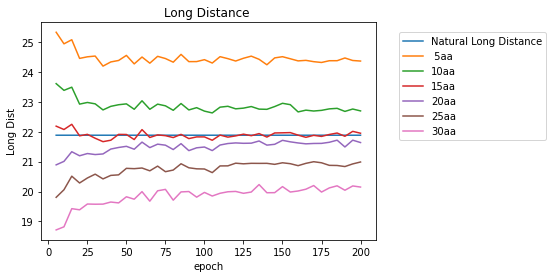

In [8]:
print(f"####################********Test dataset******###############################")
import matplotlib.pyplot as plt
ep=[num*5 for num in list(range(1,len(TotalARRareSameInpainting_5)+1))]
#plt.plot(ep,TotalARRareSameInpainting)
plt.plot(ep, TotalARRareSameInpaintingMM_5 )
plt.plot(ep, TotalARRareSameInpaintingMM_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD inpainted protein structure's distance matrix")
plt.show()


plt.plot(ep, TotalARRareSameInpainting_5 )
plt.plot(ep, TotalARRareSameInpainting_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameInpainting_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameInpainting_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameInpainting_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameInpainting_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameInpainting_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD")
plt.show()

plt.plot(ep, TotalARRareSameMatrix_5 )
plt.plot(ep, TotalARRareSameMatrix_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameMatrix_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameMatrix_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameMatrix_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameMatrix_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameMatrix_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD Generated protein structure's distance matrix")
plt.show()


plt.plot(ep, TotalARRareSameSSIMRegen_5 )
plt.plot(ep, TotalARRareSameSSIMRegen_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("SSIM ")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"SSIM Regenerated protein structure's distance matrix")
plt.show()


plt.plot(ep, TotalNBackBoneDist,label="Natural BackBoneDist")
plt.plot(ep, TotalBackBoneDist_5, label="5aa"   )
plt.plot(ep, TotalBackBoneDist_10, label="10aa"   )
plt.plot(ep, TotalBackBoneDist_15, label="15aa"   )
plt.plot(ep, TotalBackBoneDist_20, label="20aa"   )
plt.plot(ep, TotalBackBoneDist_25, label="25aa"   )
plt.plot(ep, TotalBackBoneDist_30, label="30aa"   )
plt.ylabel("BackBone Dist")
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.title(f"BackBoneDist")
plt.show()


plt.plot(ep, TotalNshortDist,label="Natural short Distance")
plt.plot(ep, TotalshortDist_5, label="5aa"   )
plt.plot(ep, TotalshortDist_10, label="10aa" )
plt.plot(ep, TotalshortDist_15, label="15aa" )
plt.plot(ep, TotalshortDist_20, label="20aa" )
plt.plot(ep, TotalshortDist_25, label="25aa" )
plt.plot(ep, TotalshortDist_30, label="30aa" )
plt.ylabel("short Distance")
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.title(f"short Distance ")
plt.show()

plt.plot(ep, TotalNLongDist, label="Natural Long Distance")
plt.plot(ep, TotalLongDist_5, label=" 5aa"  )
plt.plot(ep, TotalLongDist_10, label="10aa" )
plt.plot(ep, TotalLongDist_15, label="15aa" )
plt.plot(ep, TotalLongDist_20, label="20aa" )
plt.plot(ep, TotalLongDist_25, label="25aa" )
plt.plot(ep, TotalLongDist_30, label="30aa" )
plt.ylabel("Long Dist")
plt.xlabel("epoch")
plt.title(f"Long Distance ")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.show()


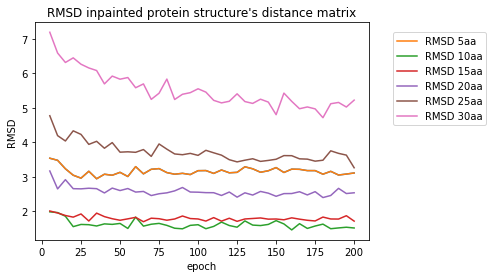

In [9]:
ep=[num*5 for num in list(range(1,len(TotalARRareSameInpainting_5)+1))]
#plt.plot(ep,TotalARRareSameInpainting)
plt.plot(ep, TotalARRareSameInpaintingMM_5 )
plt.plot(ep, TotalARRareSameInpaintingMM_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameInpaintingMM_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD inpainted protein structure's distance matrix")
plt.show()


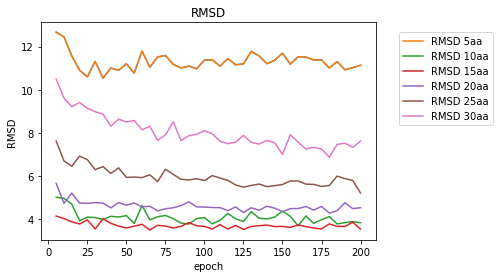

In [10]:


plt.plot(ep, TotalARRareSameInpainting_5 )
plt.plot(ep, TotalARRareSameInpainting_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameInpainting_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameInpainting_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameInpainting_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameInpainting_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameInpainting_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD")
plt.show()

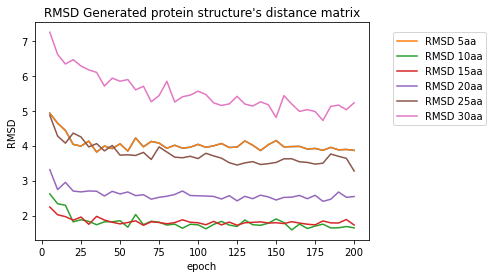

In [11]:


plt.plot(ep, TotalARRareSameMatrix_5 )
plt.plot(ep, TotalARRareSameMatrix_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameMatrix_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameMatrix_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameMatrix_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameMatrix_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameMatrix_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("RMSD")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"RMSD Generated protein structure's distance matrix")
plt.show()



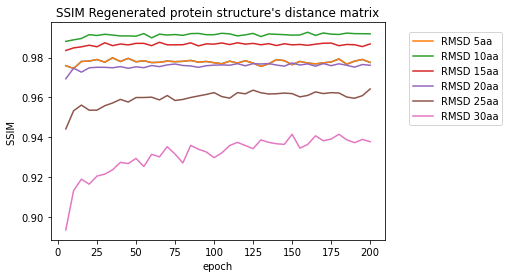

In [12]:

plt.plot(ep, TotalARRareSameSSIMRegen_5 )
plt.plot(ep, TotalARRareSameSSIMRegen_5 , label="RMSD 5aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_10, label="RMSD 10aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_15, label="RMSD 15aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_20, label="RMSD 20aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_25, label="RMSD 25aa"   )
plt.plot(ep, TotalARRareSameSSIMRegen_30, label="RMSD 30aa"   )

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.ylabel("SSIM ")
plt.xlabel("epoch")
#plt.ylim(2,5)
plt.title(f"SSIM Regenerated protein structure's distance matrix")
plt.show()

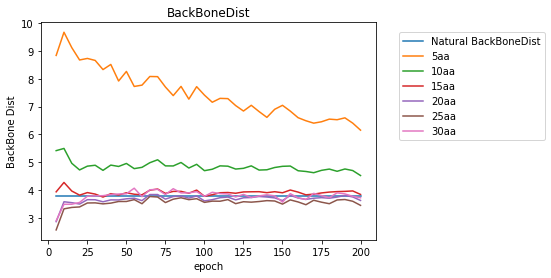

In [13]:


plt.plot(ep, TotalNBackBoneDist,label="Natural BackBoneDist")
plt.plot(ep, TotalBackBoneDist_5, label="5aa"   )
plt.plot(ep, TotalBackBoneDist_10, label="10aa"   )
plt.plot(ep, TotalBackBoneDist_15, label="15aa"   )
plt.plot(ep, TotalBackBoneDist_20, label="20aa"   )
plt.plot(ep, TotalBackBoneDist_25, label="25aa"   )
plt.plot(ep, TotalBackBoneDist_30, label="30aa"   )
plt.ylabel("BackBone Dist")
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.title(f"BackBoneDist")
plt.show()


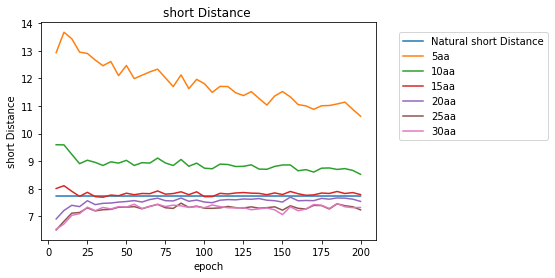

In [14]:

plt.plot(ep, TotalNshortDist,label="Natural short Distance")
plt.plot(ep, TotalshortDist_5, label="5aa"   )
plt.plot(ep, TotalshortDist_10, label="10aa" )
plt.plot(ep, TotalshortDist_15, label="15aa" )
plt.plot(ep, TotalshortDist_20, label="20aa" )
plt.plot(ep, TotalshortDist_25, label="25aa" )
plt.plot(ep, TotalshortDist_30, label="30aa" )
plt.ylabel("short Distance")
plt.xlabel("epoch")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.title(f"short Distance ")
plt.show()


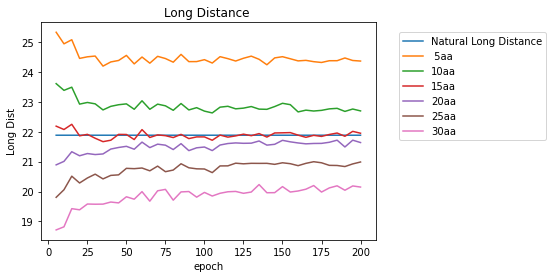

In [15]:

plt.plot(ep, TotalNLongDist, label="Natural Long Distance")
plt.plot(ep, TotalLongDist_5, label=" 5aa"  )
plt.plot(ep, TotalLongDist_10, label="10aa" )
plt.plot(ep, TotalLongDist_15, label="15aa" )
plt.plot(ep, TotalLongDist_20, label="20aa" )
plt.plot(ep, TotalLongDist_25, label="25aa" )
plt.plot(ep, TotalLongDist_30, label="30aa" )
plt.ylabel("Long Dist")
plt.xlabel("epoch")
plt.title(f"Long Distance ")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
plt.show()
